<div style="background-color:#EAF4EC; padding:20px; border-radius:10px;">

<h2 style="color:#2F6F4E; text-align:center; margin-bottom:5px;">
Data Preparation — Preprocessing Pipeline
</h2>

<h4 style="color:#2F6F4E; text-align:center; margin-top:0;">
Master Thesis – ESG Governance Indicators (EU-27)
</h4>

<p style="font-size:14px; color:#2F6F4E;">
This notebook implements the <strong>Data Preprocessing</strong> stage of the CRISP-ML(Q) methodology.<br>
The goal is to transform the raw governance indicators into a <strong>clean, consistent, and analysis-ready</strong> dataset.
</p>

<p style="font-size:14px; color:#2F6F4E;">
This notebook modifies the dataset and outputs the cleaned version used in all subsequent modeling steps.
</p>

</div>

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler

In [2]:
DATA_PATH = Path("../data/processed/esg_gov17_eu27.csv")
df_wide = pd.read_csv(DATA_PATH)

I create a working copy of the original dataset (`df_wide`) to ensure that
all preprocessing steps are applied safely, without modifying the raw data.


In [3]:
# Working copy for preprocessing
df = df_wide.copy()

print("df_wide shape:", df_wide.shape)
print("df_wide.copy shape:", df.shape)

df_wide shape: (459, 68)
df_wide.copy shape: (459, 68)


<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
Missing values 
</h2>

<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
1. Detecting Missing Values 
</h2>

In [4]:
# Identify year columns
year_cols = [c for c in df.columns if c.isdigit()]
year_cols = sorted(year_cols)

# Missingness per indicator
missing_indicators = df[year_cols].isna().mean(axis=1) * 100
df["missing_pct"] = missing_indicators

print("Average missingness across the dataset: {:.2f}%".format(df["missing_pct"].mean()))
df[["Indicator Code", "missing_pct"]].head()

Average missingness across the dataset: 53.89%


Indicator Code  missing_pct
0             CC.EST      60.9375
1     SD.ESR.PERF.XQ      81.2500
2  NY.GDP.MKTP.KD.ZG       1.5625
3             GE.EST      60.9375
4     IT.NET.USER.ZS      46.8750

In [5]:
missing_by_indicator = (
    df.groupby("Indicator Code")[year_cols]
      .apply(lambda x: x.isna().mean().mean() * 100)
      .sort_values(ascending=False)
)

missing_by_indicator


Indicator Code
SP.UWT.TFRT          98.842593
SD.ESR.PERF.XQ       81.250000
CC.EST               60.937500
PV.EST               60.937500
RQ.EST               60.937500
RL.EST               60.937500
GE.EST               60.937500
VA.EST               60.937500
GB.XPD.RSDV.GD.ZS    59.375000
SG.GEN.PARL.ZS       58.159722
IP.JRN.ARTC.SC       57.812500
IT.NET.USER.ZS       48.553241
SL.TLF.CACT.FM.ZS    46.875000
IP.PAT.RESD          43.981481
SE.ENR.PRSC.FM.ZS    35.821759
NY.GDP.MKTP.KD.ZG    19.791667
SM.POP.NETM           0.000000
dtype: float64

In [6]:
# Identify year columns
year_cols = [c for c in df.columns if c.isdigit()]
year_cols = sorted(year_cols)

# Compute missingness by year
missing_by_year = df[year_cols].isna().mean() * 100

print("Missingness by year (%):")
missing_by_year


Missingness by year (%):


1960    94.117647
1961    90.849673
1962    90.849673
1963    90.849673
1964    90.849673
          ...    
2019    11.982571
2020    11.764706
2021    17.647059
2022    23.529412
2023    35.294118
Length: 64, dtype: float64

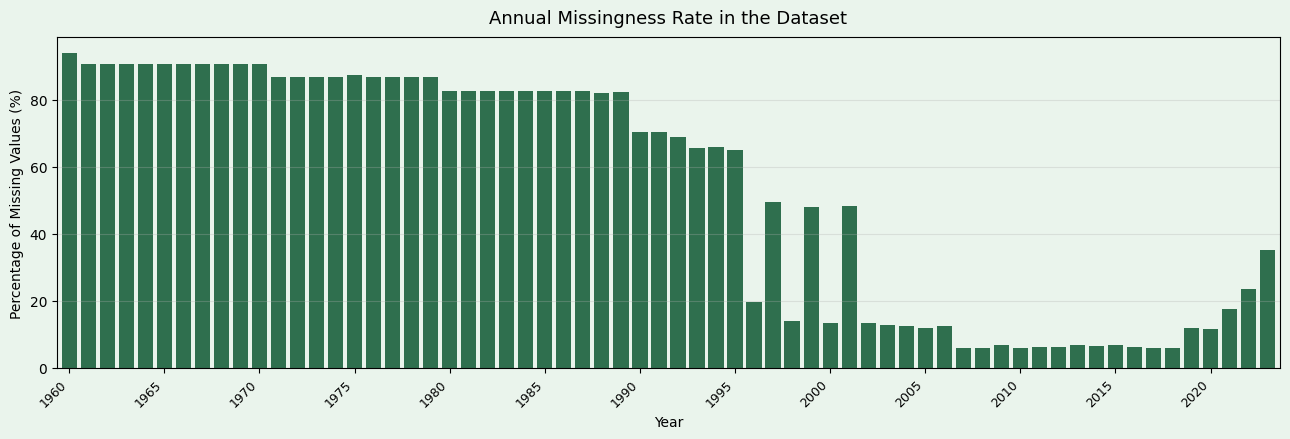

In [7]:
ACCENT = "#2F6F4E"
BACKGROUND = "#EAF4EC"

fig, ax = plt.subplots(figsize=(13, 4.5))
fig.patch.set_facecolor(BACKGROUND)
ax.set_facecolor(BACKGROUND)

missing_by_year.plot(
    kind="bar",
    ax=ax,
    color=ACCENT,
    width=0.8
)

ax.set_title("Annual Missingness Rate in the Dataset", fontsize=13, pad=10)
ax.set_xlabel("Year")
ax.set_ylabel("Percentage of Missing Values (%)")

# Improve x-axis readability
ax.set_xticks(range(0, len(missing_by_year), 5))
ax.set_xticklabels(
    missing_by_year.index[::5],
    rotation=45,
    ha="right",
    fontsize=9
)

# Subtle grid
ax.grid(axis="y", alpha=0.3)
ax.grid(axis="x", visible=False)

plt.tight_layout()
plt.show()


<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
2. Restrict the Dataset
</h2>

#### Restrict the Dataset to a Reliable Time Window (2000–2023)

Based on the missingness analysis, the years before 2000 show substantially
higher data gaps across most indicators.  
To ensure a stable and balanced panel for forecasting, clustering, and
explainability, we restrict the dataset to the period **2000–2023**.

Missingness analysis revealed that data availability before 2000 was highly inconsistent across indicators.
To ensure a reliable and balanced panel, the temporal scope was restricted to 2000–2023.

Several governance indicators were only introduced in more recent years, which naturally results in structural missingness in the earlier decades of the dataset. This reinforces the need to restrict the temporal scope to a period where all indicators are consistently reported.

In [8]:
# Identify year columns
year_cols = [c for c in df.columns if c.isdigit()]
year_cols = sorted(year_cols)

# Select only years from 2000 onward
keep_years = [y for y in year_cols if int(y) >= 2000]

# Keep only relevant columns in df
df = df[["Country Name", "Country Code", "Indicator Name", "Indicator Code"] + keep_years]

print(df.shape)

(459, 28)


In [9]:
# Remove early-year columns
year_cols = [c for c in df.columns if c.isdigit()]
keep_years = [y for y in year_cols if int(y) >= 2000]

df = df[["Country Name", "Country Code", "Indicator Name", "Indicator Code"] + keep_years]

# Remove rows (indicators) with no data from 2000 onward
df = df.dropna(subset=keep_years, how="all")

print(df.shape)

(436, 28)


In [10]:
total_cells = df.shape[0] * (df.shape[1] - 4)   # remove metadata columns

# Nan across all years 
year_cols = [c for c in df.columns if c.isdigit()]
missing_cells = df[year_cols].isna().sum().sum()

missing_pct = missing_cells / total_cells * 100

print("Total cells (years only):", total_cells)
print("Missing cells:", missing_cells)
print("Missing percentage: {:.2f}%".format(missing_pct))

Total cells (years only): 10464
Missing cells: 829
Missing percentage: 7.92%


In [11]:
year_cols = sorted([c for c in df.columns if c.isdigit()])
keep_years = [y for y in year_cols if 2000 <= int(y) <= 2023]

# Missing % por indicador (agregado em todos os países)
missing_by_indicator = (
    df.groupby("Indicator Code")[keep_years]
      .apply(lambda x: x.isna().mean().mean() * 100)
      .sort_values(ascending=False)
)

missing_df = missing_by_indicator.reset_index()
missing_df.columns = ["Indicator Code", "missing_pct"]
missing_df


Indicator Code  missing_pct
0         SP.UWT.TFRT    92.708333
1      SD.ESR.PERF.XQ    50.000000
2   SE.ENR.PRSC.FM.ZS    14.506173
3         IP.PAT.RESD    14.351852
4   GB.XPD.RSDV.GD.ZS     5.401235
5              CC.EST     4.166667
6              RQ.EST     4.166667
7              RL.EST     4.166667
8              PV.EST     4.166667
9      IP.JRN.ARTC.SC     4.166667
10             GE.EST     4.166667
11             VA.EST     4.166667
12     SG.GEN.PARL.ZS     0.771605
13  NY.GDP.MKTP.KD.ZG     0.000000
14     IT.NET.USER.ZS     0.000000
15  SL.TLF.CACT.FM.ZS     0.000000
16        SM.POP.NETM     0.000000

<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
3. Removing variables with excessive missingness: > 15%
</h2> 

In [12]:
threshold = 15
indicators_to_keep = missing_df.loc[missing_df["missing_pct"] <= threshold, "Indicator Code"]

df_filtered = df[df["Indicator Code"].isin(indicators_to_keep)].copy()

print("Rows before:", df.shape[0])
print("Rows after:", df_filtered.shape[0])
print("Indicators before:", df["Indicator Code"].nunique())
print("Indicators after:", df_filtered["Indicator Code"].nunique())

Rows before: 436
Rows after: 405
Indicators before: 17
Indicators after: 15


+ SP.UWT.TFRT — removed due to structural missingness, as it contains no data after 2000.

+ SD.ESR.PERF.XQ — removed for exceeding the 15% missingness threshold in the 2000–2023 period.

In [13]:
def missing_summary_years(df, years):
    total_cells = df.shape[0] * len(years)
    missing_cells = df[years].isna().sum().sum()
    pct = (missing_cells / total_cells) * 100
    return total_cells, missing_cells, pct

before_cells, before_missing, before_pct = missing_summary_years(df_wide, keep_years)
after_cells, after_missing, after_pct = missing_summary_years(df_filtered, keep_years)


print("=== Missingness Comparison ===")
print(f"Before filtering: {before_missing}/{before_cells}  ({before_pct:.2f}%)")
print(f"After filtering:  {after_missing}/{after_cells}   ({after_pct:.2f}%)")
print(f"Improvement:      {before_pct - after_pct:.2f}%")

=== Missingness Comparison ===
Before filtering: 1381/11016  (12.54%)
After filtering:  416/9720   (4.28%)
Improvement:      8.26%


In [14]:
# Missing % indicator
missing_by_indicator = (
    df_filtered.groupby("Indicator Code")[keep_years]
    .apply(lambda x: x.isna().mean().mean() * 100)
    .sort_values(ascending=False)
)

missing_df = missing_by_indicator.reset_index()
missing_df.columns = ["Indicator Code","missing_pct"]

missing_df

Indicator Code  missing_pct
0   SE.ENR.PRSC.FM.ZS    14.506173
1         IP.PAT.RESD    14.351852
2   GB.XPD.RSDV.GD.ZS     5.401235
3              CC.EST     4.166667
4              GE.EST     4.166667
5      IP.JRN.ARTC.SC     4.166667
6              PV.EST     4.166667
7              RL.EST     4.166667
8              RQ.EST     4.166667
9              VA.EST     4.166667
10     SG.GEN.PARL.ZS     0.771605
11     IT.NET.USER.ZS     0.000000
12  NY.GDP.MKTP.KD.ZG     0.000000
13  SL.TLF.CACT.FM.ZS     0.000000
14        SM.POP.NETM     0.000000

###  Indicators with No Missing Values 
After restricting the dataset to the reliable period **2000–2023** and applying the 15% missingness rule, four indicators show **0% missing values**, meaning their time series are fully complete for all EU-27 countries:

- **IT.NET.USER.ZS** – Individuals using the Internet (% of population)  
- **NY.GDP.MKTP.KD.ZG** – GDP growth (annual %)  
- **SL.TLF.CACT.FM.ZS** – Ratio of female to male labor force participation  
- **SM.POP.NETM** – Net migration  

These variables **require no imputation** and can be used directly in the forecasting and clustering models.  
Their completeness also increases the stability of the panel and reduces uncertainty in downstream ML tasks.


In [15]:
complete_indicators = missing_df.loc[missing_df["missing_pct"] == 0, "Indicator Code"].tolist()
complete_indicators


['IT.NET.USER.ZS', 'NY.GDP.MKTP.KD.ZG', 'SL.TLF.CACT.FM.ZS', 'SM.POP.NETM']

<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
4. Linear Interpolation to Fill Missing Values
</h2>

### Linear Interpolation Applied

Based on the nature of the variables, linear interpolation was applied only to indicators expected to evolve smoothly over time:

- **SE.ENR.PRSC.FM.ZS** – School enrolment (primary and secondary)
- **GB.XPD.RSDV.GD.ZS** – R&D expenditure (% of GDP)

These indicators exhibit gradual trends and do not show structural jumps, making linear interpolation appropriate.  
Missing values were imputed as follows:

1. **Linear interpolation across years (axis=1)**  
2. **Forward-fill and backward-fill** to address gaps at the beginning or end of the series  

This ensures continuity in the time series while respecting the expected behaviour of the variables.

In [16]:
# Indicators to aplly linear interpolation
indicators_linear = ["SE.ENR.PRSC.FM.ZS", "GB.XPD.RSDV.GD.ZS"]

df_imputed = df_filtered.copy()

year_cols = [c for c in df_imputed.columns if c.isdigit()]
year_cols = sorted(year_cols)

for ind in indicators_linear:
    df_imputed.loc[df_imputed["Indicator Code"] == ind, year_cols] = (
        df_imputed.loc[df_imputed["Indicator Code"] == ind, year_cols]
        .interpolate(axis=1, method="linear", limit_direction="both")
        .ffill(axis=1)
        .bfill(axis=1)
    )

print("Missing values AFTER interpolation (linear indicators only):")
print(df_imputed[df_imputed["Indicator Code"].isin(indicators_linear)][year_cols].isna().sum().sum())


Missing values AFTER interpolation (linear indicators only):
0


In [17]:
df_imputed[df_imputed["Indicator Code"].isin(indicators_linear)][year_cols].isna().sum()


2000    0
2001    0
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
2017    0
2018    0
2019    0
2020    0
2021    0
2022    0
2023    0
dtype: int64

<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
5. Foeward-fill and backward-fill 
</h2> 

### Imputation of Remaining Missing Values

After restricting the analysis to 2000–2023 and removing indicators with more than 15% missingness, a small fraction (~2.8%) of missing values remained.

These missing values were handled using indicator-specific strategies:

- **Linear interpolation** was applied to smooth and continuous indicators:
  - `SE.ENR.PRSC.FM.ZS`
  - `GB.XPD.RSDV.GD.ZS`

- **Forward-fill and backward-fill (ffill + bfill)** were applied to governance and discrete indicators where linear interpolation would not be theoretically appropriate:
  - World Governance Indicators: `CC.EST`, `GE.EST`, `PV.EST`, `RL.EST`, `RQ.EST`, `VA.EST`
  - Patent applications: `IP.PAT.RESD`
  - Scientific articles: `IP.JRN.ARTC.SC`
  - Women in parliament: `SG.GEN.PARL.ZS`

After applying these procedures, **all remaining missing values were successfully imputed**, resulting in a fully balanced dataset for the period 2000–2023.


In [18]:
# Indicators to apply ffill() + bfill()
indicators_ffill = [
    "IP.PAT.RESD",       # Patents
    "IP.JRN.ARTC.SC",    # Journal articles
    "CC.EST", "GE.EST", "PV.EST", "RL.EST", "RQ.EST", "VA.EST",  # WGI
    "SG.GEN.PARL.ZS"     # Parliament % women (só um ou dois misses)
]

for ind in indicators_ffill:
    df_imputed.loc[df_imputed["Indicator Code"] == ind, year_cols] = (
        df_imputed.loc[df_imputed["Indicator Code"] == ind, year_cols]
        .ffill(axis=1)
        .bfill(axis=1)
    )


In [19]:
(df_imputed[df_imputed["Indicator Code"].isin(indicators_ffill)][year_cols]
 .isna().sum().sum())


np.int64(0)

#### Testing if there is still missing values 

In [20]:
df_imputed.isna().sum().sum()

np.int64(0)

In [21]:
(
    df_imputed.groupby("Indicator Code")[year_cols]
    .apply(lambda x: x.isna().sum().sum())
)

Indicator Code
CC.EST               0
GB.XPD.RSDV.GD.ZS    0
GE.EST               0
IP.JRN.ARTC.SC       0
IP.PAT.RESD          0
IT.NET.USER.ZS       0
NY.GDP.MKTP.KD.ZG    0
PV.EST               0
RL.EST               0
RQ.EST               0
SE.ENR.PRSC.FM.ZS    0
SG.GEN.PARL.ZS       0
SL.TLF.CACT.FM.ZS    0
SM.POP.NETM          0
VA.EST               0
dtype: int64

In [22]:
for ind in ["GB.XPD.RSDV.GD.ZS", "SE.ENR.PRSC.FM.ZS"]:
    temp = df_imputed[df_imputed["Indicator Code"] == ind][year_cols]
    print(ind, " -> países sem qualquer dado:", (temp.notna().sum(axis=1) == 0).sum())


GB.XPD.RSDV.GD.ZS  -> países sem qualquer dado: 0
SE.ENR.PRSC.FM.ZS  -> países sem qualquer dado: 0


In [23]:
to_fix = ["GB.XPD.RSDV.GD.ZS", "SE.ENR.PRSC.FM.ZS"]

for ind in to_fix:
    mask = df_imputed["Indicator Code"] == ind
    
    # temporal interpolation
    df_imputed.loc[mask, year_cols] = (
        df_imputed.loc[mask, year_cols]
        .interpolate(axis=1, method="linear", limit_direction="both")
        .ffill(axis=1)
        .bfill(axis=1)
    )

In [24]:
(
    df_imputed.groupby("Indicator Code")[year_cols]
    .apply(lambda x: x.isna().sum().sum())
)

Indicator Code
CC.EST               0
GB.XPD.RSDV.GD.ZS    0
GE.EST               0
IP.JRN.ARTC.SC       0
IP.PAT.RESD          0
IT.NET.USER.ZS       0
NY.GDP.MKTP.KD.ZG    0
PV.EST               0
RL.EST               0
RQ.EST               0
SE.ENR.PRSC.FM.ZS    0
SG.GEN.PARL.ZS       0
SL.TLF.CACT.FM.ZS    0
SM.POP.NETM          0
VA.EST               0
dtype: int64

In [25]:
df_imputed.isna().sum().sum()


np.int64(0)

In [26]:
df_imputed.isna().sum()

Country Name      0
Country Code      0
Indicator Name    0
Indicator Code    0
2000              0
2001              0
2002              0
2003              0
2004              0
2005              0
2006              0
2007              0
2008              0
2009              0
2010              0
2011              0
2012              0
2013              0
2014              0
2015              0
2016              0
2017              0
2018              0
2019              0
2020              0
2021              0
2022              0
2023              0
dtype: int64

In [27]:
df_imputed.groupby("Indicator Code")[year_cols] \
       .apply(lambda x: x.isna().sum().sum())

Indicator Code
CC.EST               0
GB.XPD.RSDV.GD.ZS    0
GE.EST               0
IP.JRN.ARTC.SC       0
IP.PAT.RESD          0
IT.NET.USER.ZS       0
NY.GDP.MKTP.KD.ZG    0
PV.EST               0
RL.EST               0
RQ.EST               0
SE.ENR.PRSC.FM.ZS    0
SG.GEN.PARL.ZS       0
SL.TLF.CACT.FM.ZS    0
SM.POP.NETM          0
VA.EST               0
dtype: int64

<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
Outliers   
</h2> 

In [28]:
year_cols = [c for c in df_imputed.columns if c.isdigit()]

outliers_list = []

for (country, indicator), group in df_imputed.groupby(["Country Name", "Indicator Code"]):
    values = group[year_cols].iloc[0].astype(float)

    if values.std() == 0:
        continue

    z_scores = ((values - values.mean()) / values.std()).abs()
    outlier_years = z_scores[z_scores > 3]

    for year, z in outlier_years.items():
        outliers_list.append({
            "Country": country,
            "Indicator": indicator,
            "Year": int(year),
            "Value": values[year],
            "Z_score": z 
})

outliers_df = pd.DataFrame(outliers_list)

In [29]:
outliers_df.shape
outliers_df.groupby("Indicator").size().sort_values(ascending=False)


Indicator
SM.POP.NETM          9
NY.GDP.MKTP.KD.ZG    8
IP.PAT.RESD          1
IT.NET.USER.ZS       1
SG.GEN.PARL.ZS       1
VA.EST               1
dtype: int64

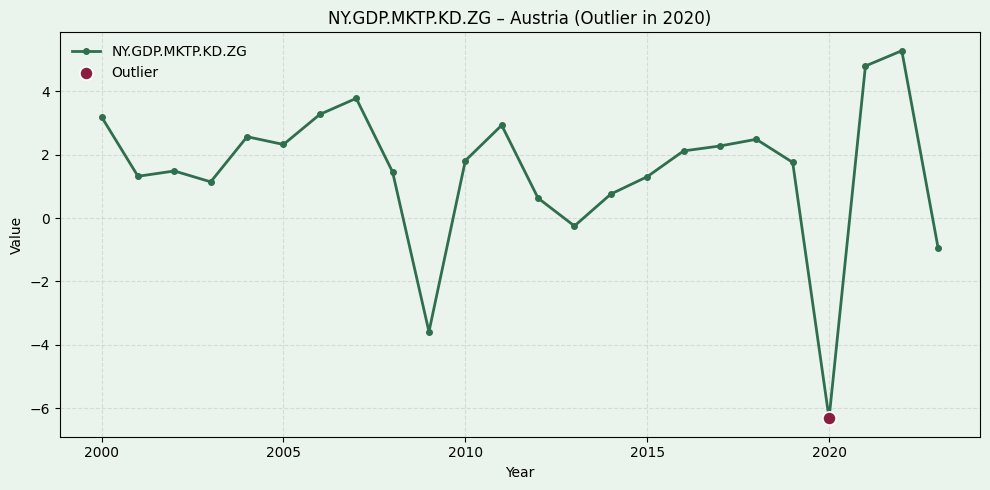

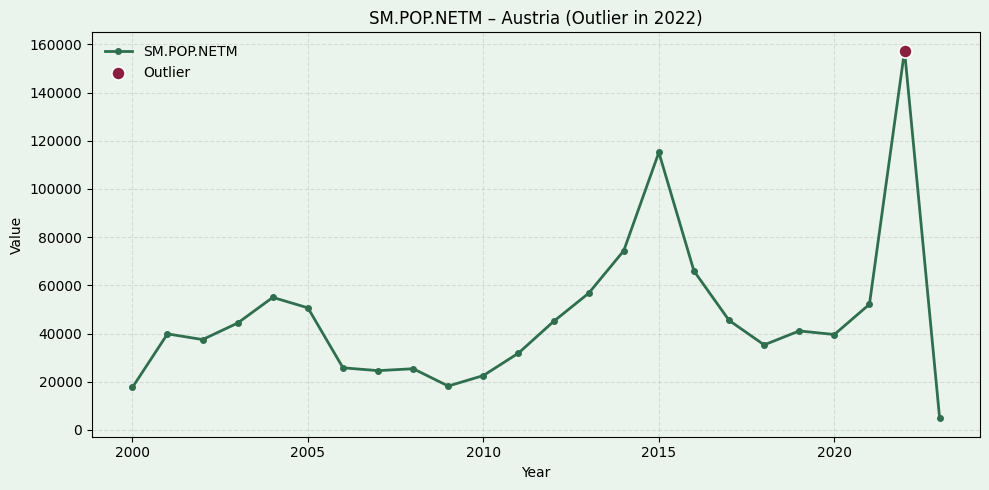

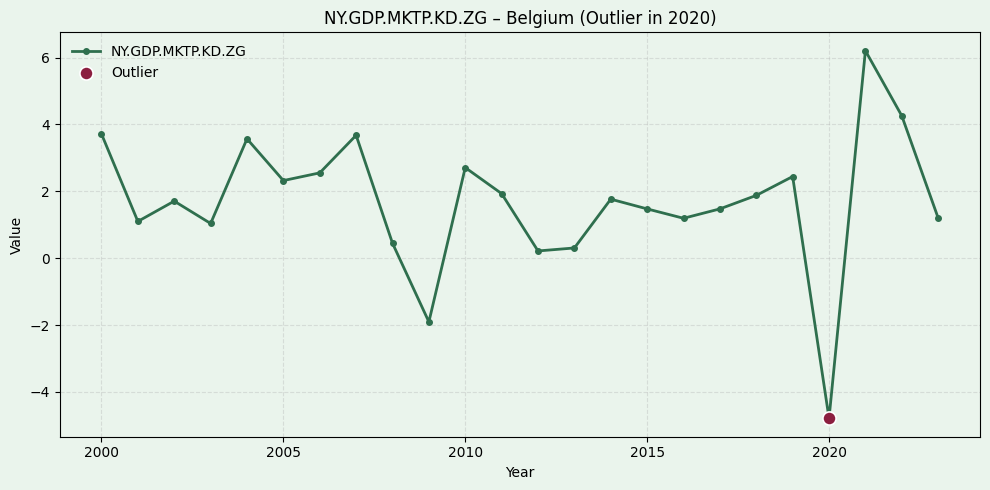

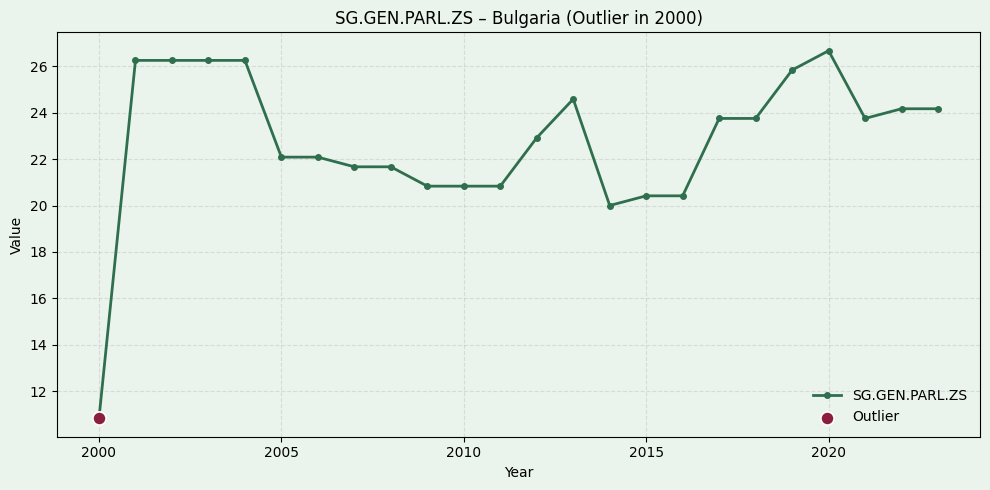

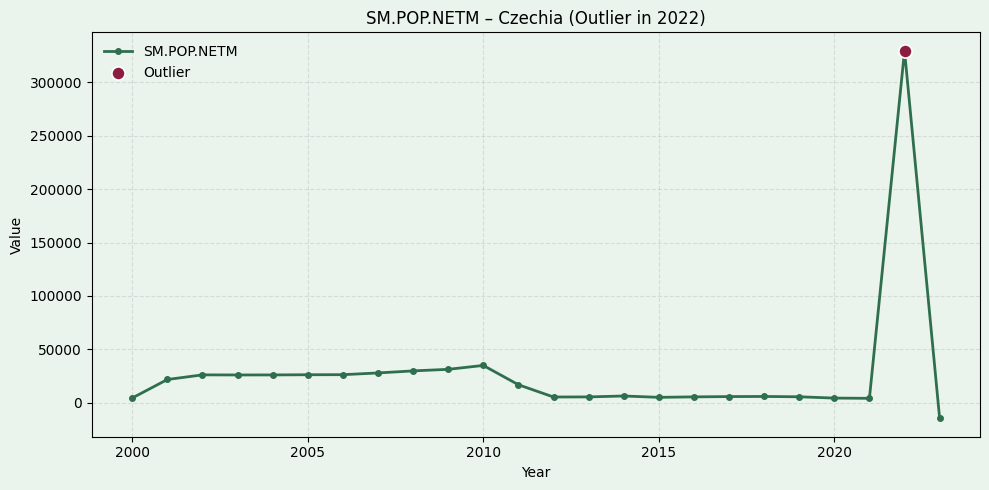

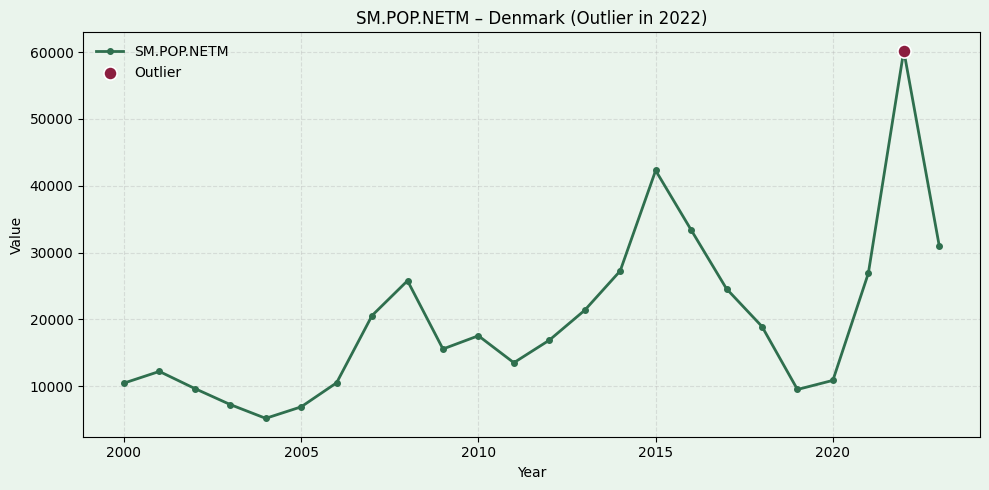

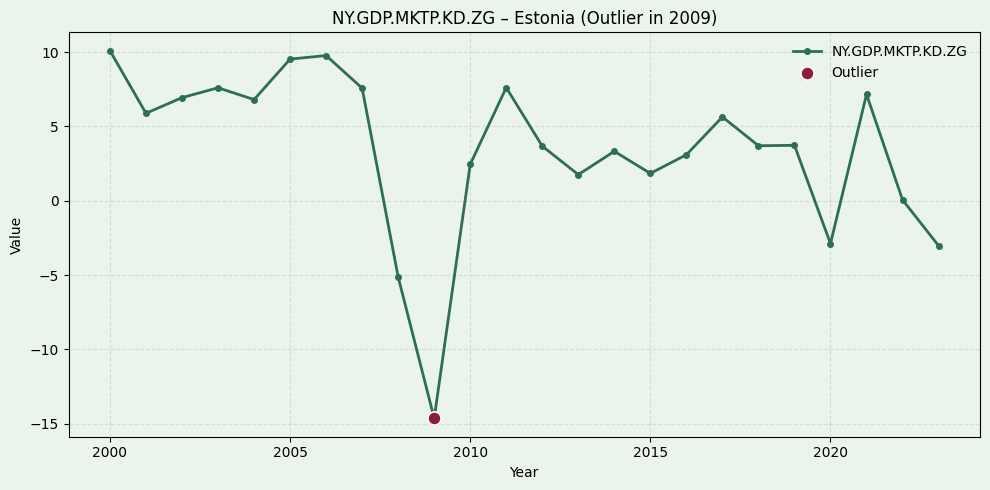

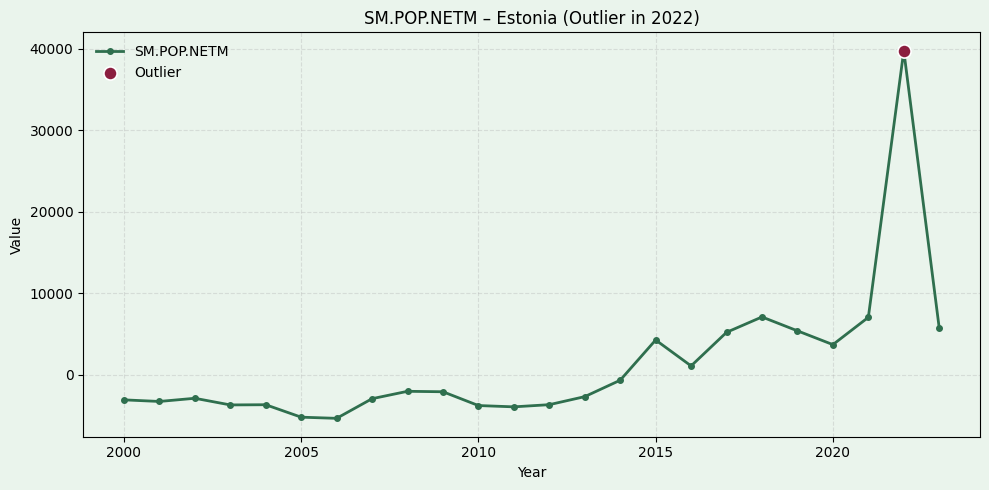

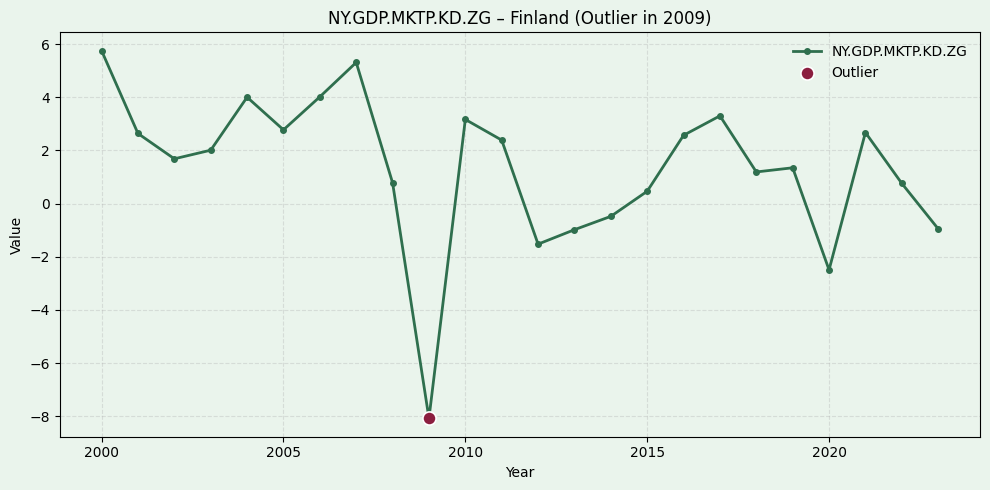

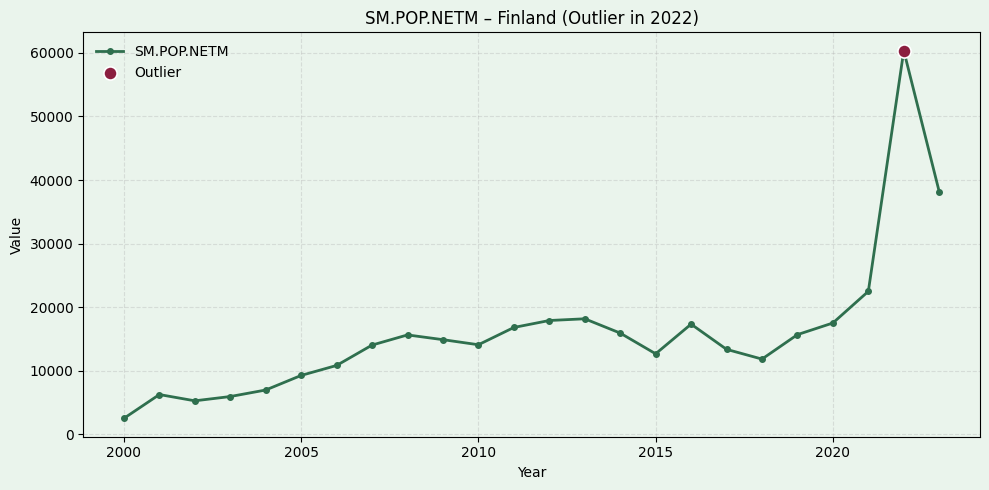

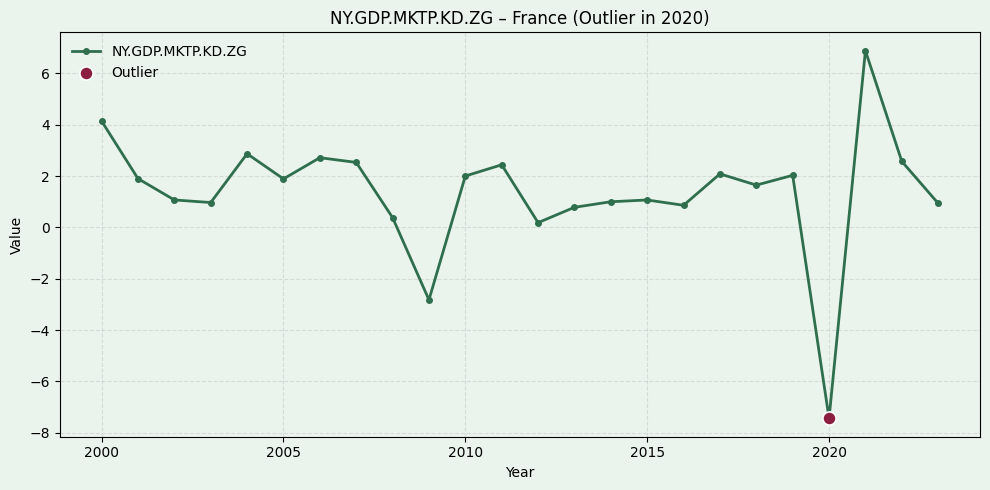

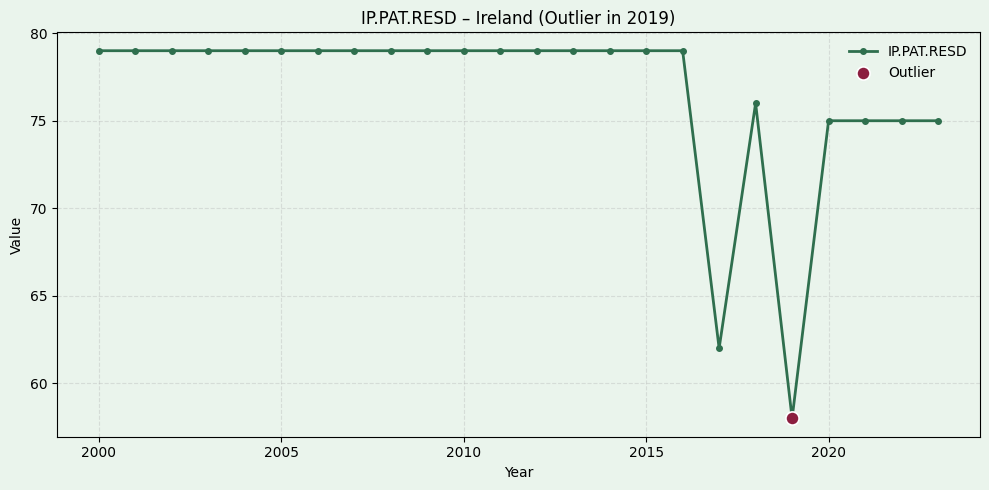

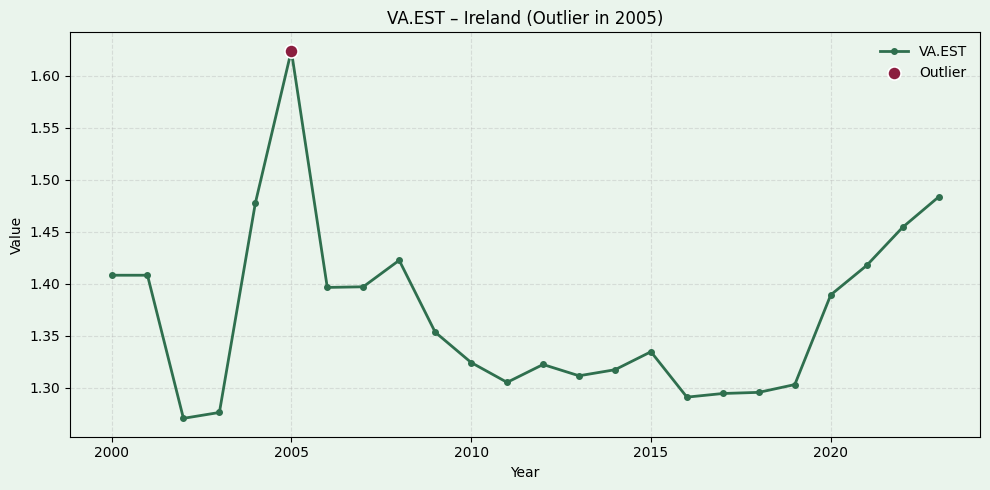

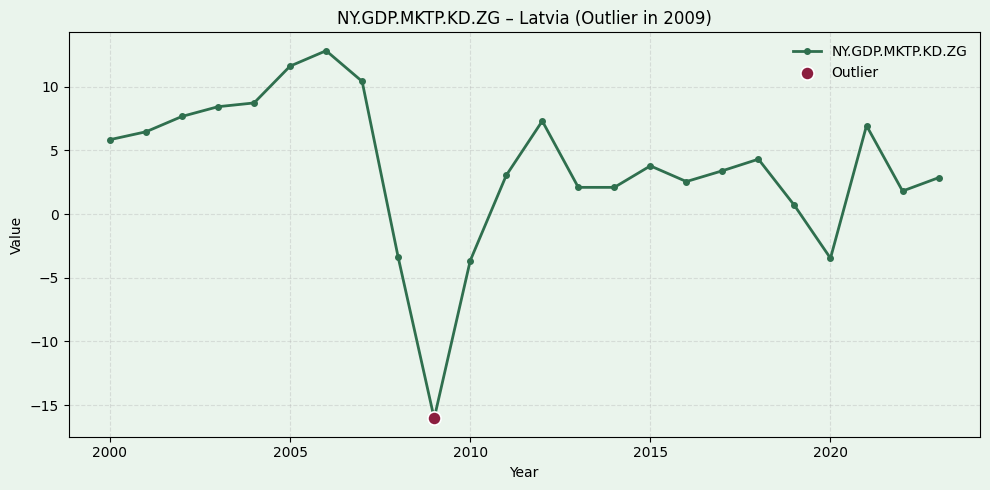

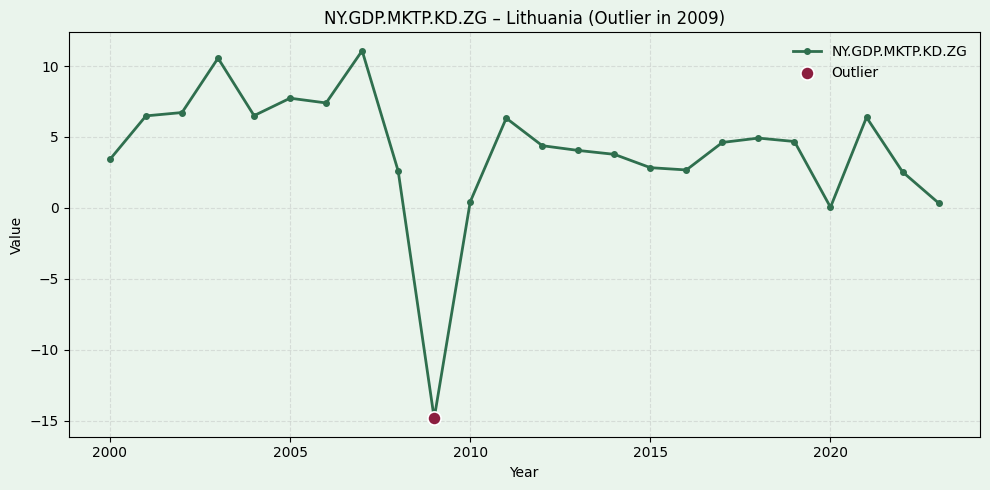

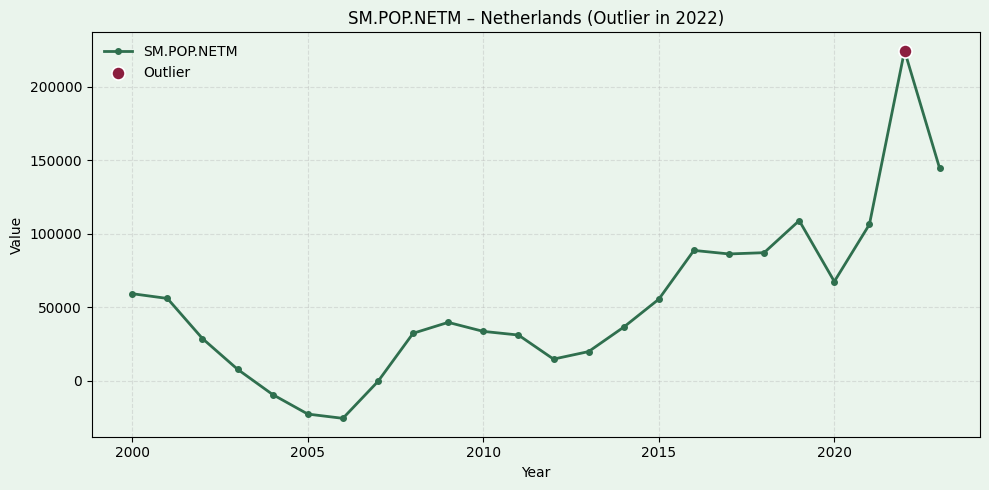

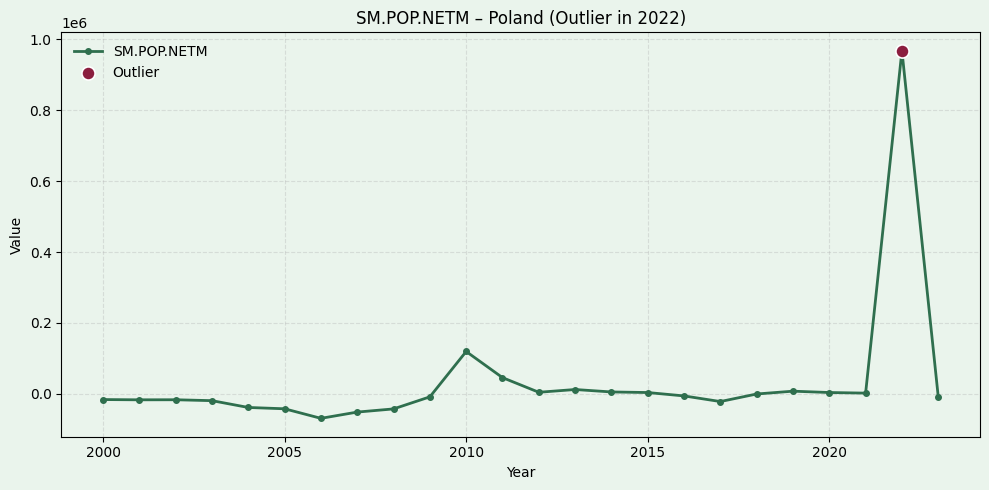

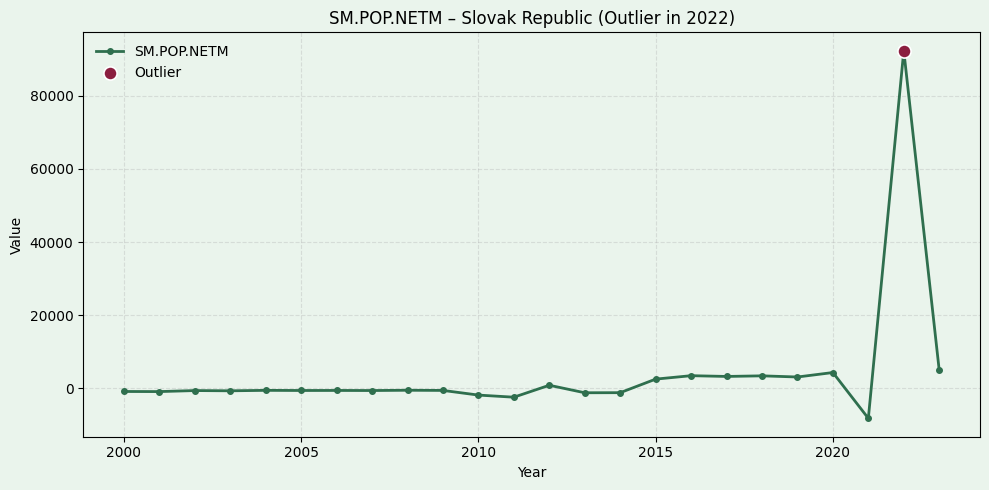

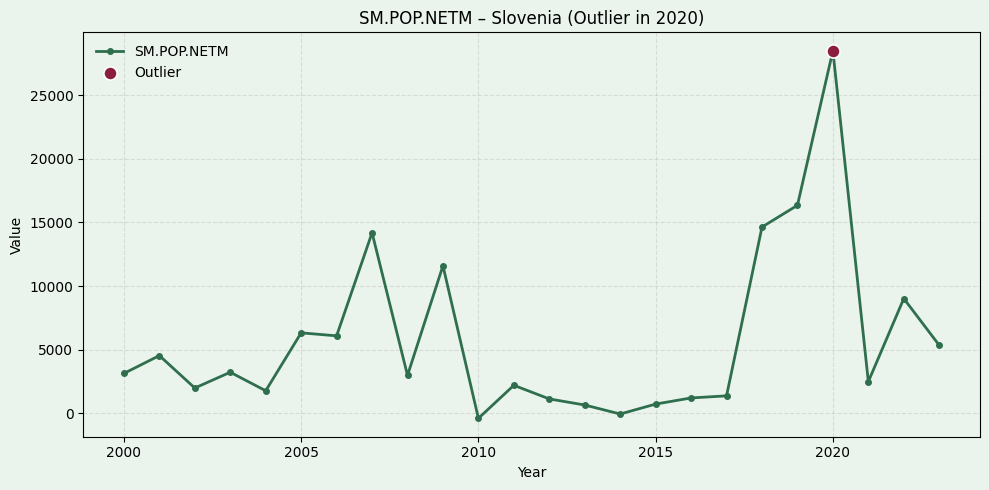

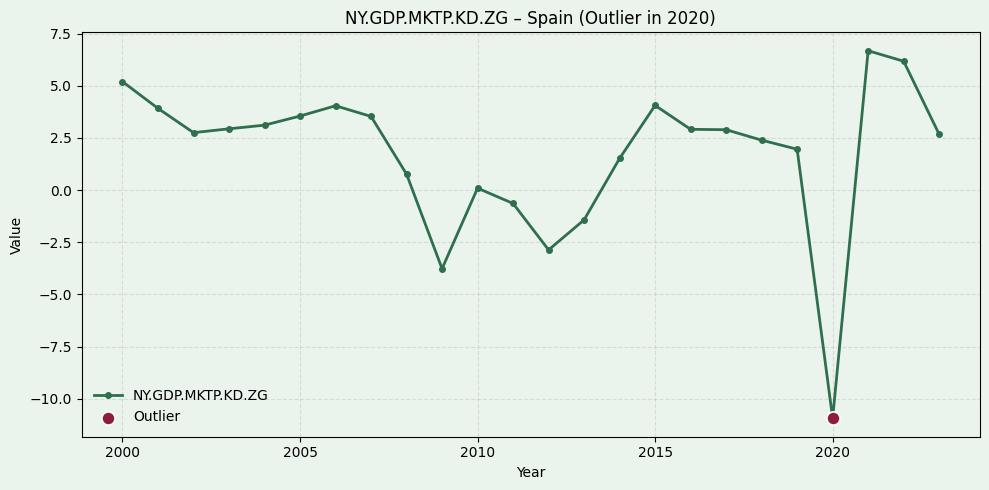

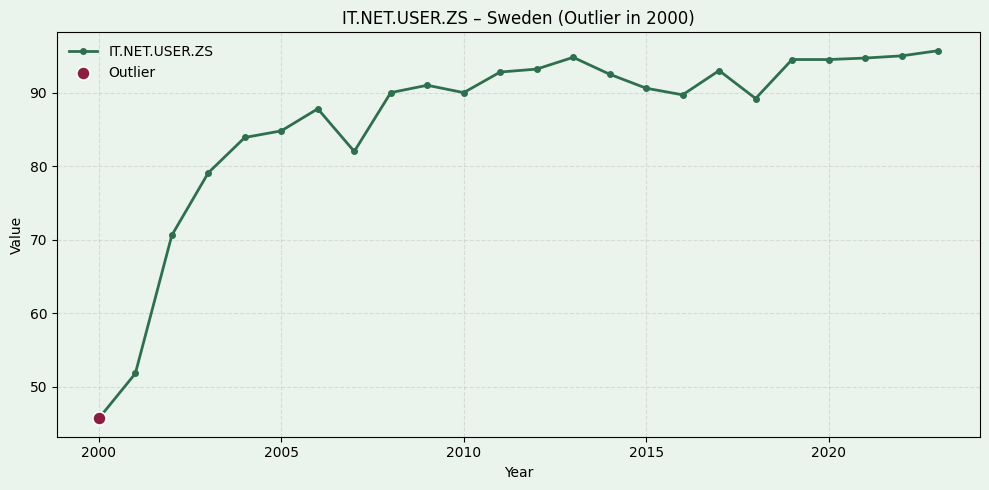

In [30]:
ACCENT = "#2F6F4E"       # green
BACKGROUND = "#EAF4EC"   # light background
OUTLIER = "#8B1E3F"      # dark red

year_cols = [c for c in df_imputed.columns if c.isdigit()]
years = list(map(int, year_cols))

for _, row in outliers_df.iterrows():
    
    country = row["Country"]
    indicator = row["Indicator"]
    year_out = int(row["Year"])
    value_out = row["Value"]
    
    series = df_imputed[
        (df_imputed["Country Name"] == country) &
        (df_imputed["Indicator Code"] == indicator)
    ][year_cols].values.flatten()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor(BACKGROUND)
    ax.set_facecolor(BACKGROUND)

    # Time series
    ax.plot(
        years,
        series,
        marker="o",
        linewidth=2,
        markersize=4,
        color=ACCENT,
        label=indicator
    )

    # Outlier
    ax.scatter(
        year_out,
        value_out,
        color=OUTLIER,
        s=90,
        edgecolor="white",
        linewidth=1.2,
        zorder=5,
        label="Outlier"
    )

    ax.set_title(f"{indicator} – {country} (Outlier in {year_out})")
    ax.set_xlabel("Year")
    ax.set_ylabel("Value")

    ax.grid(True, linestyle="--", alpha=0.35)
    ax.legend(frameon=False)

    plt.tight_layout()
    plt.show()




In [31]:
df_final = df_imputed.copy()
year_cols = [c for c in df_final.columns if c.isdigit()]

In [32]:
corrections = [
    # --- SM.POP.NETM ---
    ("Austria",     "SM.POP.NETM"),
    ("Czechia",     "SM.POP.NETM"),
    ("Denmark",     "SM.POP.NETM"),
    ("Estonia",     "SM.POP.NETM"),
    ("Finland",     "SM.POP.NETM"),
    ("Netherlands", "SM.POP.NETM"),
    ("Poland",      "SM.POP.NETM"),
    ("Slovakia",    "SM.POP.NETM"),
    ("Slovenia",    "SM.POP.NETM"),

    # --- SG.GEN.PARL.ZS ---
    ("Bulgaria",    "SG.GEN.PARL.ZS"),
    ("Malta",       "SG.GEN.PARL.ZS"),
]

def correct_series(df, country, indicator, year_cols):
    mask = (
        (df["Country Name"] == country) &
        (df["Indicator Code"] == indicator)
    )

    df.loc[mask, year_cols] = (
        df.loc[mask, year_cols]
        .astype(float)
        .interpolate(axis=1, method="linear", limit_direction="both")
    )

    return df

for country, indicator in corrections:
    df_final = correct_series(df_final, country, indicator, year_cols)


In [33]:
df_final.isna().sum().sum()

np.int64(0)

### Outlier Treatment

Outliers were identified using univariate Z-score analysis (|Z| > 3) at the country–indicator level and assessed through visual inspection and domain knowledge. The detected extreme values were found to reflect genuine socio-economic and institutional shocks rather than data errors. 

Although interpolation was tested for selected indicators as a sensitivity check, no outlier correction was applied to the final dataset. All observations were retained, with the influence of extreme values addressed at later stages through appropriate scaling and model selection.

<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
DATA SCALING, ENCODING AND NORMALIZATION 
</h2>  

### Encoding Categorical Variables

No categorical encoding techniques were required in this study.  
Country names and indicator codes are retained solely as **identifiers** to preserve
the panel structure (country × indicator × year) and are not used as input features
in the modeling stage.


### Data Scaling and Normalization

Governance indicators exhibit heterogeneous measurement scales, including
percentages, index-based scores, and absolute values. To ensure comparability
across indicators and prevent scale-driven bias in machine learning algorithms,
numerical variables were standardized prior to modeling.

Z-score normalization was applied using **StandardScaler**, rescaling each indicator
to have zero mean and unit variance. Scaling was performed **per indicator**, while
preserving the temporal and country-level structure of the panel dataset.

This approach ensures that all governance dimensions contribute equally to
distance-based methods such as clustering and supports stable learning behavior
in predictive models.

Outlier-sensitive scaling methods were not required, as outliers had already been
identified and treated in a previous preprocessing step.

In [34]:
#There are no missing values left
df_final.isna().sum().sum()

np.int64(0)

In [35]:
df_scaled = df_final.copy()

# 2) Identificar colunas de anos (aceita colunas int ou str)
year_cols = [c for c in df_scaled.columns if str(c).isdigit()]

# 3) Garantir que são numéricas (float) + checar inf
df_scaled[year_cols] = df_scaled[year_cols].apply(pd.to_numeric, errors="coerce")

if np.isinf(df_scaled[year_cols].to_numpy()).any():
    raise ValueError("Encontrados valores +inf/-inf nas colunas de anos. Corrige antes de escalar.")

# (opcional mas recomendado) confirmar que não tens NaN antes do scaling
n_nans_before = int(df_scaled[year_cols].isna().sum().sum())
print("NaNs antes do scaling (anos):", n_nans_before)
if n_nans_before != 0:
    raise ValueError("Ainda tens NaNs nas colunas de anos. Resolve antes do scaling.")

# 4) Scaling por indicador (across country×year)
scaler = StandardScaler()

for ind, idx in df_scaled.groupby("Indicator Code").groups.items():
    block = df_scaled.loc[idx, year_cols].to_numpy(dtype=float)  # shape (n_rows, n_years)

    flat = block.reshape(-1, 1)  # junta todos os países+anos desse indicador
    flat_scaled = scaler.fit_transform(flat)

    df_scaled.loc[idx, year_cols] = flat_scaled.reshape(block.shape)

print(" Scaling done.")

# 5) Checks 
print("NaNs after scaling:", int(df_scaled[year_cols].isna().sum().sum()))


NaNs antes do scaling (anos): 0
 Scaling done.
NaNs after scaling: 0


In [36]:
check = (
    df_scaled.groupby("Indicator Code")[year_cols]
    .apply(lambda x: pd.Series({
        "mean_all": np.mean(x.to_numpy()),
        "std_all":  np.std(x.to_numpy(), ddof=0)
    }))
)

check.sort_values("std_all").head(17)

mean_all  std_all
Indicator Code                          
RQ.EST            -2.247859e-16      1.0
CC.EST            -1.398059e-16      1.0
GB.XPD.RSDV.GD.ZS -7.675616e-17      1.0
GE.EST            -4.386066e-17      1.0
IP.JRN.ARTC.SC    -1.644775e-16      1.0
IT.NET.USER.ZS     2.631640e-16      1.0
NY.GDP.MKTP.KD.ZG -2.193033e-17      1.0
PV.EST             9.868649e-17      1.0
RL.EST             1.452884e-16      1.0
SE.ENR.PRSC.FM.ZS -3.843291e-15      1.0
SG.GEN.PARL.ZS    -1.096517e-16      1.0
SM.POP.NETM       -2.193033e-17      1.0
VA.EST             1.589949e-16      1.0
IP.PAT.RESD       -1.370646e-18      1.0
SL.TLF.CACT.FM.ZS  5.482583e-16      1.0

### Scaling Validation

To verify the correctness of the scaling procedure, summary statistics were computed for each indicator across all countries and years. The results confirm that, after standardization, all indicators exhibit an approximately zero mean and a unit standard deviation.

Minor deviations from zero in the mean (on the order of 1e−16) are due to floating-point precision and can be interpreted as numerical zero. These results confirm that Z-score standardization using `StandardScaler` was successfully applied per indicator, ensuring scale comparability while preserving the underlying panel structure.

In [37]:
from pathlib import Path

# define folder to save processed data
OUTPUT_DIR = Path("../data/processed")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# save the scaled dataframe to CSV
df_scaled.to_csv(
    OUTPUT_DIR / "data_scaled_governance_EU27.csv",
    index=False
)

print("data_scaled_governance_EU27.csv saved.")


data_scaled_governance_EU27.csv saved.


In [38]:
# save the final datafame to use in forecasting
df_final.to_csv(
    "../data/processed/data_final_governance_EU27.csv",
    index=False
)
print("data_final_governance_EU27.csv saved.")

data_final_governance_EU27.csv saved.
